## Predicting Recurrence of Differentiated Thyroid Cancer Using Deep Learning Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scikeras.wrappers import KerasClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Libraries for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### Load the Dataset

In [2]:
data_path = '../data.csv'
df = pd.read_csv(data_path)

In [3]:
# Display the first few rows
print(df.head())

   Age Gender Smoking Hx Smoking Hx Radiothreapy Thyroid Function  \
0   27      F      No         No              No        Euthyroid   
1   34      F      No        Yes              No        Euthyroid   
2   30      F      No         No              No        Euthyroid   
3   62      F      No         No              No        Euthyroid   
4   62      F      No         No              No        Euthyroid   

          Physical Examination Adenopathy       Pathology     Focality Risk  \
0   Single nodular goiter-left         No  Micropapillary    Uni-Focal  Low   
1          Multinodular goiter         No  Micropapillary    Uni-Focal  Low   
2  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
3  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
4          Multinodular goiter         No  Micropapillary  Multi-Focal  Low   

     T   N   M Stage       Response Recurred  
0  T1a  N0  M0     I  Indeterminate       No  
1  T1a  N0  M0  

In [4]:
# Check data info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

In [5]:
# Dataset columns
df.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

### Exploratory Data Analysis (EDA)

In [6]:
# Check for missing values
print(df.isnull().sum())

Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64


In [7]:
# Get descriptive statistics for numerical data
print(df.describe())

              Age
count  383.000000
mean    40.866841
std     15.134494
min     15.000000
25%     29.000000
50%     37.000000
75%     51.000000
max     82.000000


In [8]:
# Check unique values in categorical columns
for column in df.select_dtypes(include='object').columns:
    print(f"{column}: {df[column].unique()}")

Gender: ['F' 'M']
Smoking: ['No' 'Yes']
Hx Smoking: ['No' 'Yes']
Hx Radiothreapy: ['No' 'Yes']
Thyroid Function: ['Euthyroid' 'Clinical Hyperthyroidism' 'Clinical Hypothyroidism'
 'Subclinical Hyperthyroidism' 'Subclinical Hypothyroidism']
Physical Examination: ['Single nodular goiter-left' 'Multinodular goiter'
 'Single nodular goiter-right' 'Normal' 'Diffuse goiter']
Adenopathy: ['No' 'Right' 'Extensive' 'Left' 'Bilateral' 'Posterior']
Pathology: ['Micropapillary' 'Papillary' 'Follicular' 'Hurthel cell']
Focality: ['Uni-Focal' 'Multi-Focal']
Risk: ['Low' 'Intermediate' 'High']
T: ['T1a' 'T1b' 'T2' 'T3a' 'T3b' 'T4a' 'T4b']
N: ['N0' 'N1b' 'N1a']
M: ['M0' 'M1']
Stage: ['I' 'II' 'IVB' 'III' 'IVA']
Response: ['Indeterminate' 'Excellent' 'Structural Incomplete'
 'Biochemical Incomplete']
Recurred: ['No' 'Yes']


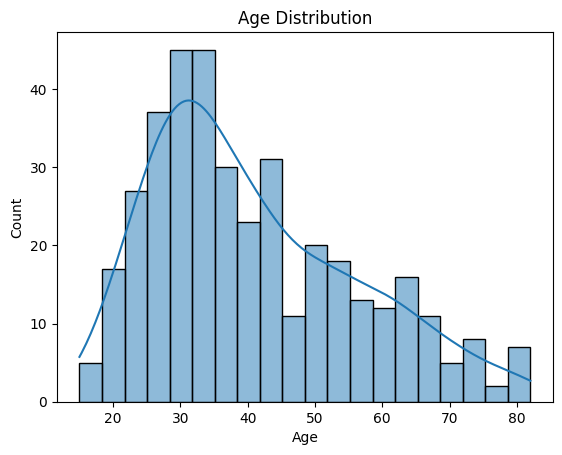

In [9]:
# Distribution of Age
sns.histplot(df['Age'], kde=True, bins=20)
plt.title("Age Distribution")
plt.show()


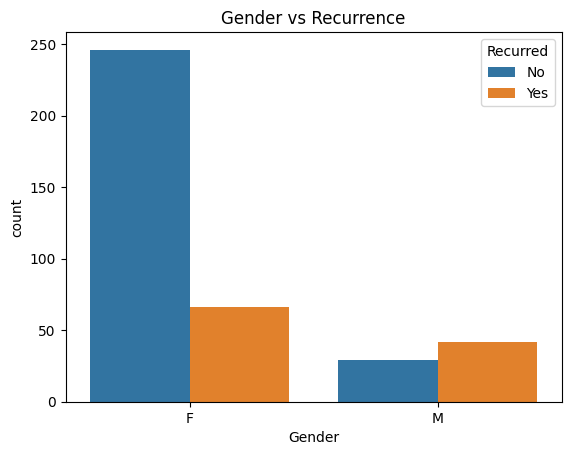

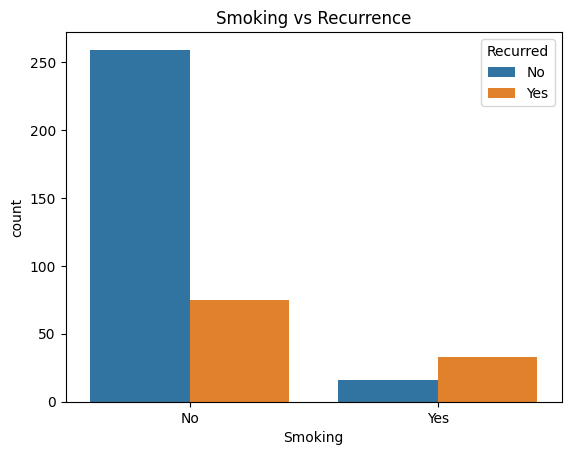

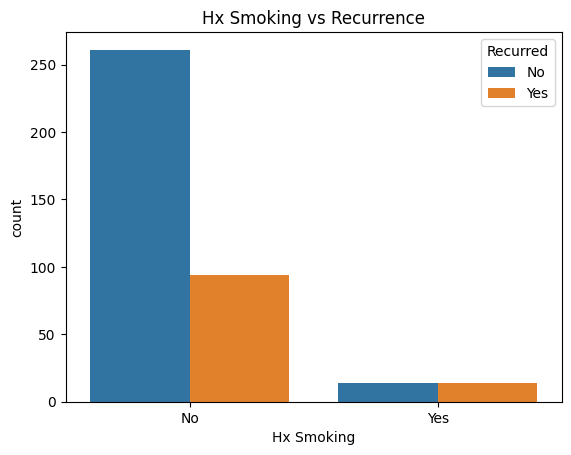

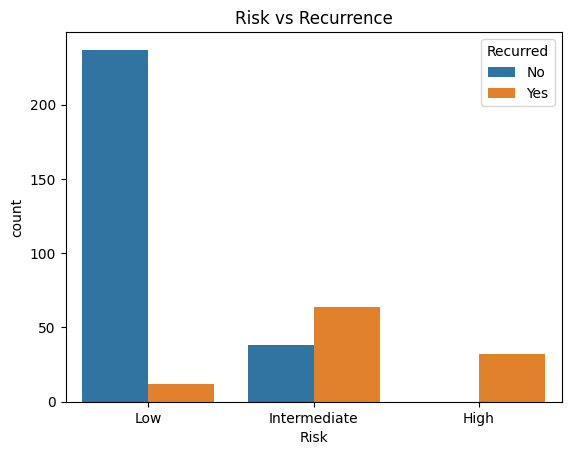

In [10]:
# Check how recurrence is related to Gender, Smoking, etc.
for column in ['Gender', 'Smoking', 'Hx Smoking', 'Risk']:
    sns.countplot(data=df, x=column, hue='Recurred')
    plt.title(f"{column} vs Recurrence")
    plt.show()

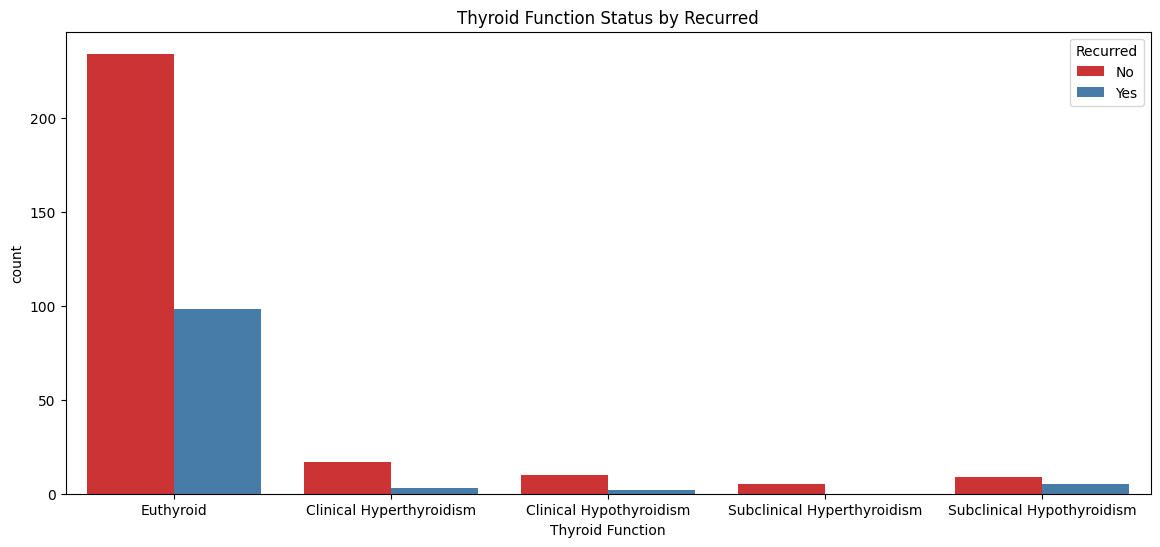

In [11]:
# Plot thyroid function based on recurrence cases
plt.figure(figsize=(14, 6))
sns.countplot(x='Thyroid Function', hue='Recurred', data=df, palette='Set1')
plt.title('Thyroid Function Status by Recurred')
plt.show()

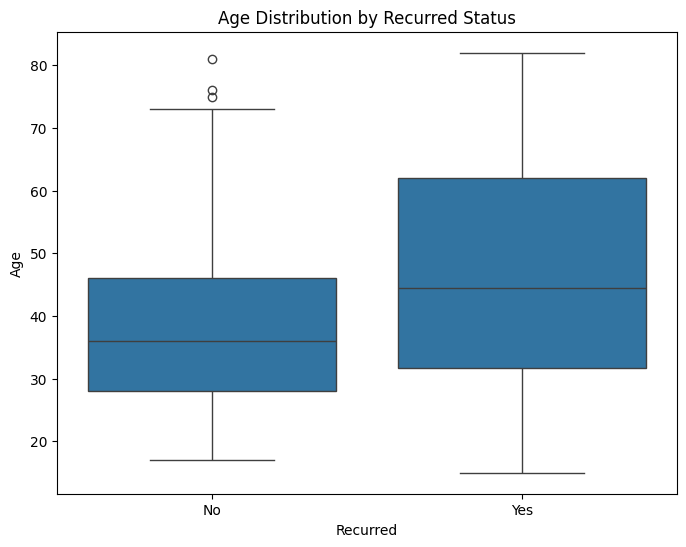

In [12]:
# Explore feature distributions
plt.figure(figsize=(8, 6))
sns.boxplot(x='Recurred', y='Age', data=df)
plt.title('Age Distribution by Recurred Status')
plt.show()


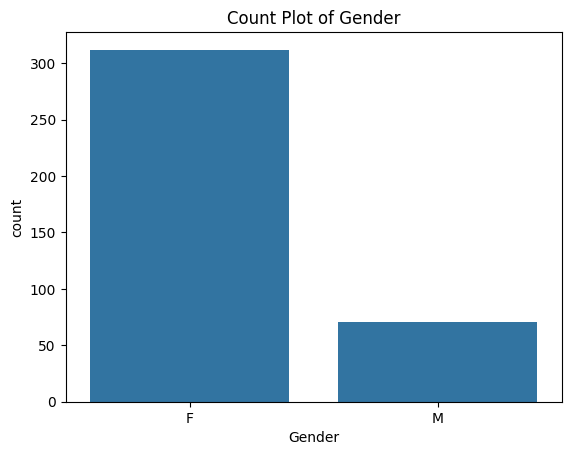

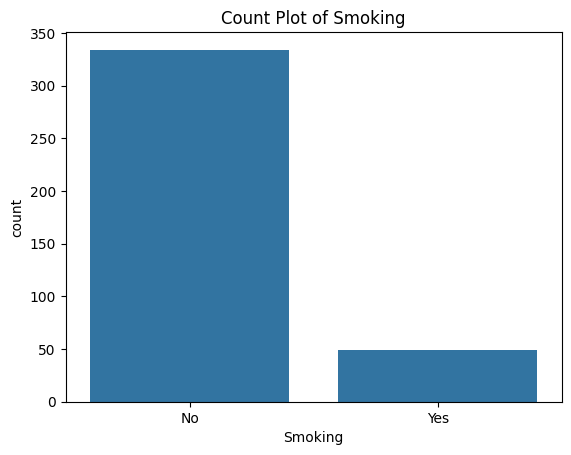

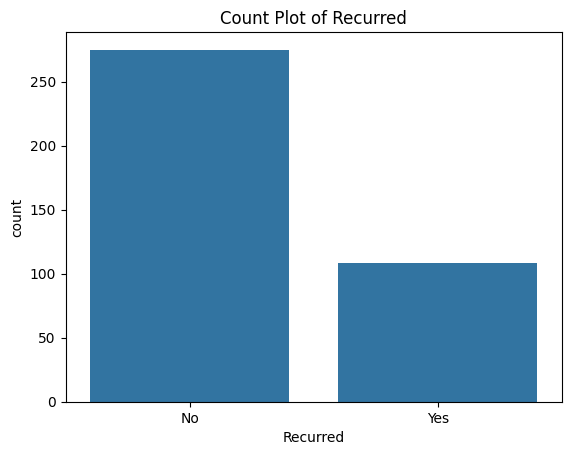

In [13]:
# Count plot for categorical variables
categorical_columns = ['Gender', 'Smoking', 'Recurred']
for column in categorical_columns:
    sns.countplot(data=df, x=column)
    plt.title(f"Count Plot of {column}")
    plt.show()

### Data Preprocessing

In [14]:
# Encode categorical variables
label_encoder = LabelEncoder()
for column in df.select_dtypes(include='object').columns:
    df[column] = label_encoder.fit_transform(df[column])

print(df.head())

   Age  Gender  Smoking  Hx Smoking  Hx Radiothreapy  Thyroid Function  \
0   27       0        0           0                0                 2   
1   34       0        0           1                0                 2   
2   30       0        0           0                0                 2   
3   62       0        0           0                0                 2   
4   62       0        0           0                0                 2   

   Physical Examination  Adenopathy  Pathology  Focality  Risk  T  N  M  \
0                     3           3          2         1     2  0  0  0   
1                     1           3          2         1     2  0  0  0   
2                     4           3          2         1     2  0  0  0   
3                     4           3          2         1     2  0  0  0   
4                     1           3          2         0     2  0  0  0   

   Stage  Response  Recurred  
0      0         2         0  
1      0         1         0  
2      0   

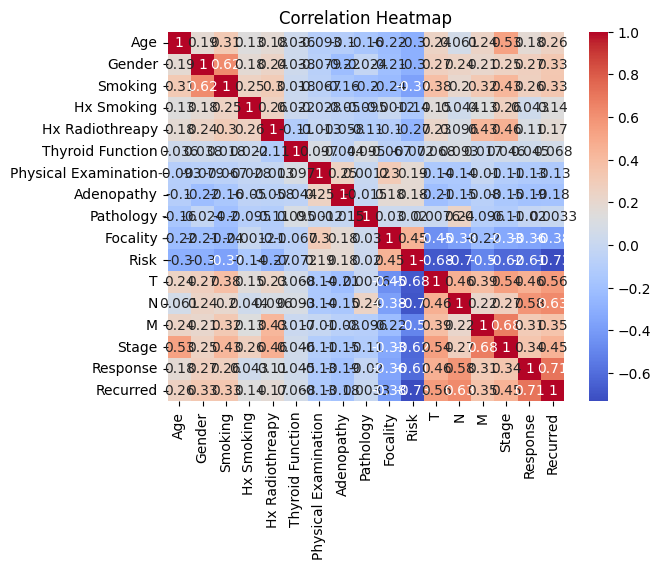

In [15]:
# Correlation heatmap
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [16]:
# Scale Age
scaler = StandardScaler()
df['Age'] = scaler.fit_transform(df[['Age']])
df ['Age'].head() 


0   -0.917439
1   -0.454315
2   -0.718957
3    1.398184
4    1.398184
Name: Age, dtype: float64

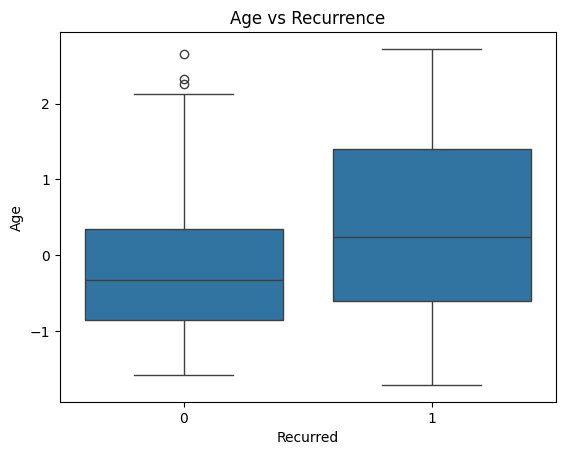

In [17]:
# Examine if age is a significant factor in recurrence.
sns.boxplot(data=df, x='Recurred', y='Age')
plt.title("Age vs Recurrence")
plt.show()


In [18]:
# Define features and target variable
X = df.drop('Recurred', axis=1)  # All columns except the target
y = df['Recurred']  # Target column

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (306, 16)
Testing set shape: (77, 16)


### Model Training

In [19]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate the model
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"
    }
    return metrics


#### Random Forest

In [60]:
rand_forest = RandomForestClassifier(n_estimators=10, random_state=42)
rand_forest_metrics = train_and_evaluate_model(rand_forest, X_train, X_test, y_train, y_test)
print("Random Forest:", rand_forest_metrics)


Random Forest: {'Accuracy': 0.974025974025974, 'Precision': 0.9473684210526315, 'Recall': 0.9473684210526315, 'F1 Score': 0.9473684210526315, 'ROC-AUC': 0.9954627949183302}


#### Hyperparameter Tuning with RF

In [21]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Create a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV for hyperparameter tuning
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings to sample
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the model on the training data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", random_search_rf.best_params_)
print("Best Cross-Validation Accuracy:", random_search_rf.best_score_)

# Evaluate the model on the test data
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
y_pred_rf_proba = best_rf_model.predict_proba(X_test)[:, 1]  # Probability for positive class

# Calculate Metrics
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_proba)

# Print Results
print("Metrics for Random Forest:")
print(f"Best Parameters: {random_search_rf.best_params_}")
print(f"Test Accuracy: {test_accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"ROC-AUC: {roc_auc_rf:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
Best Cross-Validation Accuracy: 0.9542570068746695
Metrics for Random Forest:
Best Parameters: {'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
Test Accuracy: 0.9740
Precision: 1.0000
Recall: 0.8947
F1 Score: 0.9444
ROC-AUC: 0.9955


#### K Nearest Neighbors

In [59]:
knn = KNeighborsClassifier(n_neighbors=5)
knn_metrics = train_and_evaluate_model(knn, X_train, X_test, y_train, y_test)
print("K-Nearest Neighbors:", knn_metrics)


K-Nearest Neighbors: {'Accuracy': 0.9090909090909091, 'Precision': 0.9285714285714286, 'Recall': 0.6842105263157895, 'F1 Score': 0.7878787878787878, 'ROC-AUC': 0.9591651542649726}


#### Hyperparameter Tuning with KNN

In [23]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],       # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'leaf_size': [10, 20, 30, 40, 50]         # Leaf size in the tree
}

# Create a K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()

# Use RandomizedSearchCV for hyperparameter tuning
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings to sample
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the model on the training data
random_search_knn.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", random_search_knn.best_params_)
print("Best Cross-Validation Accuracy:", random_search_knn.best_score_)

# Evaluate the model on the test data
best_knn_model = random_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
y_pred_knn_proba = best_knn_model.predict_proba(X_test)[:, 1]

# Metrics for KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn_proba)

# Print results
print("Metrics for KNN:")
print(f"Best Parameters: {random_search_knn.best_params_}")
print(f"Test Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print(f"ROC-AUC: {roc_auc_knn:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan', 'leaf_size': 50}
Best Cross-Validation Accuracy: 0.9150185087255421
Metrics for KNN:
Best Parameters: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan', 'leaf_size': 50}
Test Accuracy: 0.9351
Precision: 0.9375
Recall: 0.7895
F1 Score: 0.8571
ROC-AUC: 0.9642


#### XG Boost

In [58]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_metrics = train_and_evaluate_model(xgb, X_train, X_test, y_train, y_test)
print("XGBoost:", xgb_metrics)


XGBoost: {'Accuracy': 0.961038961038961, 'Precision': 0.9, 'Recall': 0.9473684210526315, 'F1 Score': 0.9230769230769231, 'ROC-AUC': 0.9972776769509981}


#### Hyperparameter Tuning with XGBClassifier

In [25]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [3, 5, 7, 9, 11, 13],             # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Step size shrinkage
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],        # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Subsample ratio of columns
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],         # Minimum loss reduction for a split
    'reg_alpha': [0, 0.01, 0.1, 1, 10],            # L1 regularization
    'reg_lambda': [1, 0.1, 0.5, 1.5, 2],           # L2 regularization
    'scale_pos_weight': [1, 2, 5, 10],             # Scaling for imbalanced classes
}

# Create an XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Use RandomizedSearchCV for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings to sample
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the model on the training data
random_search_xgb.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", random_search_xgb.best_params_)
print("Best Cross-Validation Accuracy:", random_search_xgb.best_score_)

# Evaluate the model on the test data
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_xgb_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Metrics for XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)

# Print results
print("Metrics for XGBoost:")
print(f"Best Parameters: {random_search_xgb.best_params_}")
print(f"Test Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"ROC-AUC: {roc_auc_xgb:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\hamma\Documents\python_venv\trans_env\lib\site-packages\xgboost\core.py:158: UserWarning: [19:29:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best Cross-Validation Accuracy: 0.9575885774722369
Metrics for XGBoost:
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}
Test Accuracy: 0.9740
Precision: 0.9474
Recall: 0.9474
F1 Score: 0.9474
ROC-AUC: 0.9964


### Deep Neural Network

In [96]:
# Define the DNN model architecture
model = Sequential()

# Input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary output

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

c:\Users\hamma\Documents\python_venv\trans_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4405 - loss: 0.7611 - val_accuracy: 0.6935 - val_loss: 0.5888
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7566 - loss: 0.5524 - val_accuracy: 0.7097 - val_loss: 0.5532
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7627 - loss: 0.4929 - val_accuracy: 0.7581 - val_loss: 0.4700
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8150 - loss: 0.4161 - val_accuracy: 0.8065 - val_loss: 0.3987
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8572 - loss: 0.3551 - val_accuracy: 0.8065 - val_loss: 0.3683
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9027 - loss: 0.2925 - val_accuracy: 0.8548 - val_loss: 0.3319
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8680 - loss: 0.2897 - val_accuracy: 0.8710 - val_loss: 0.3110
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8674 - loss: 0.2590 - val_accuracy: 0.8548 - val_loss: 0.3320
Epoch 

In [97]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate the evaluation metrics for the DNN model
accuracy_dnn = accuracy_score(y_test, y_pred)
precision_dnn = precision_score(y_test, y_pred)
recall_dnn = recall_score(y_test, y_pred)
f1_dnn = f1_score(y_test, y_pred)
roc_auc_dnn = roc_auc_score(y_test, y_pred)

# Print the DNN model metrics
print("DNN Accuracy:", accuracy_dnn)
print("DNN Precision:", precision_dnn)
print("DNN Recall:", recall_dnn)
print("DNN F1 Score:", f1_dnn)
print("DNN ROC-AUC:", roc_auc_dnn)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
DNN Accuracy: 0.935064935064935
DNN Precision: 0.9375
DNN Recall: 0.7894736842105263
DNN F1 Score: 0.8571428571428571
DNN ROC-AUC: 0.8861161524500907


#### Hyperparameter Tuning with DNN

In [99]:
from scikeras.wrappers import KerasClassifier

# Function to create the Keras Sequential model
def create_model(optimizer='adam', activation='relu', neurons=32):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (use 'softmax' for multi-class)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model using KerasClassifier
keras_model = KerasClassifier(model=create_model, verbose=0)

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'model__neurons': [16, 32, 64, 128],  # Number of neurons in each layer
    'model__activation': ['relu', 'tanh', 'sigmoid'],  # Activation functions
    'model__optimizer': ['adam', 'rmsprop', 'sgd'],  # Optimizers
    'batch_size': [8, 16, 32, 64],  # Batch sizes
    'epochs': [50, 100, 150]  # Number of epochs
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_dnn = RandomizedSearchCV(
    estimator=keras_model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the RandomizedSearchCV on training data
random_search_dnn.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", random_search_dnn.best_params_)
print("Best Cross-Validation Accuracy:", random_search_dnn.best_score_)

# Evaluate the best model on the test set
best_dnn_model = random_search_dnn.best_estimator_
y_pred_dnn = best_dnn_model.predict(X_test)
y_pred_dnn_proba = best_dnn_model.predict_proba(X_test)[:, 1]

# Metrics for XGBoost
accuracy_dnn = accuracy_score(y_test, y_pred_dnn)
precision_dnn = precision_score(y_test, y_pred_dnn)
recall_dnn = recall_score(y_test, y_pred_dnn)
f1_dnn = f1_score(y_test, y_pred_dnn)
roc_auc_dnn = roc_auc_score(y_test, y_pred_dnn_proba)

# Print results
print("Metrics for DNN:")
print(f"Best Parameters: {random_search_dnn.best_params_}")
print(f"Test Accuracy: {accuracy_dnn:.4f}")
print(f"Precision: {precision_dnn:.4f}")
print(f"Recall: {recall_dnn:.4f}")
print(f"F1 Score: {f1_dnn:.4f}")
print(f"ROC-AUC: {roc_auc_dnn:.4f}")



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\hamma\Documents\python_venv\trans_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Parameters: {'model__optimizer': 'adam', 'model__neurons': 64, 'model__activation': 'tanh', 'epochs': 150, 'batch_size': 64}
Best Cross-Validation Accuracy: 0.9249074563722897
Metrics for DNN:
Best Parameters: {'model__optimizer': 'adam', 'model__neurons': 64, 'model__activation': 'tanh', 'epochs': 150, 'batch_size': 64}
Test Accuracy: 0.9481
Precision: 1.0000
Recall: 0.7895
F1 Score: 0.8824
ROC-AUC: 0.9855


### Simple Models Comparision

In [102]:
random_search_dnn.best_params_

{'model__optimizer': 'adam',
 'model__neurons': 64,
 'model__activation': 'tanh',
 'epochs': 150,
 'batch_size': 64}

In [61]:
# Combine metrics into a single DataFrame
results = pd.DataFrame({
    "Random Forest": rand_forest_metrics,
    "KNN": knn_metrics,
    "XGBoost": xgb_metrics
}).T

print(results)


               Accuracy  Precision    Recall  F1 Score   ROC-AUC
Random Forest  0.974026   0.947368  0.947368  0.947368  0.995463
KNN            0.909091   0.928571  0.684211  0.787879  0.959165
XGBoost        0.961039   0.900000  0.947368  0.923077  0.997278


In [98]:
# Create DNN results DataFrame
dnn_results = pd.DataFrame({
    'Accuracy': [accuracy_dnn],
    'Precision': [precision_dnn],
    'Recall': [recall_dnn],
    'F1 Score': [f1_dnn],
    'ROC-AUC': [roc_auc_dnn]
}, index=['DNN'])

# Append DNN results to the existing results DataFrame
results_df = pd.concat([results, dnn_results])
results_df

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Random Forest,0.974026,0.947368,0.947368,0.947368,0.995463
KNN,0.909091,0.928571,0.684211,0.787879,0.959165
XGBoost,0.961039,0.900000,0.947368,0.923077,0.997278
DNN,0.935065,0.937500,0.789474,0.857143,0.886116


### Hyperparamter Tuning Results Comparision

In [57]:
# Calculate metrics for Random Forest
rand_forest_metrics_hyper = {
    "Training Accuracy": accuracy_score(y_train, random_search_rf.best_estimator_.predict(X_train)),
    "Test Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1 Score": f1_score(y_test, y_pred_rf),
    "Best Parameters": random_search_rf.best_params_
}

# Calculate metrics for KNN
knn_metrics_hyper = {
    "Training Accuracy": accuracy_score(y_train, best_knn_model.predict(X_train)),
    "Test Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1 Score": f1_score(y_test, y_pred_knn),
    "Best Parameters": random_search_knn.best_params_
}

# Calculate metrics for XGBoost
xgb_metrics_hyper = {
    "Training Accuracy": accuracy_score(y_train, best_xgb_model.predict(X_train)),
    "Test Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1 Score": f1_score(y_test, y_pred_xgb),
    "Best Parameters": random_search_xgb.best_params_
}

# Create a DataFrame excluding Best Parameters for better presentation
results_hyper = pd.DataFrame({
    "Random Forest": {key: value for key, value in rand_forest_metrics_hyper.items() if key != "Best Parameters"},
    "KNN": {key: value for key, value in knn_metrics_hyper.items() if key != "Best Parameters"},
    "XGBoost": {key: value for key, value in xgb_metrics_hyper.items() if key != "Best Parameters"}
}).T

# Add the Best Parameters separately
results_hyper["Best Parameters"] = [rand_forest_metrics_hyper["Best Parameters"], knn_metrics_hyper["Best Parameters"], xgb_metrics_hyper["Best Parameters"]]

# Display the results
print(results_hyper)


               Training Accuracy  Test Accuracy  Precision    Recall  \
Random Forest           0.964052       0.974026   1.000000  0.894737   
KNN                     1.000000       0.935065   0.937500  0.789474   
XGBoost                 0.990196       0.974026   0.947368  0.947368   

               F1 Score                                    Best Parameters  
Random Forest  0.944444  {'n_estimators': 200, 'min_samples_split': 15,...  
KNN            0.857143  {'weights': 'distance', 'n_neighbors': 7, 'met...  
XGBoost        0.947368  {'subsample': 0.8, 'scale_pos_weight': 2, 'reg...  


In [103]:
random_search_dnn.best_params_

{'model__optimizer': 'adam',
 'model__neurons': 64,
 'model__activation': 'tanh',
 'epochs': 150,
 'batch_size': 64}

In [104]:
dnn_results_hyper = pd.DataFrame({
    "Training Accuracy": accuracy_score(y_train, random_search_dnn.best_estimator_.predict(X_train)),
    "Test Accuracy": accuracy_score(y_test, y_pred_dnn),
    "Precision": precision_score(y_test, y_pred_dnn),
    "Recall": recall_score(y_test, y_pred_dnn),
    "F1 Score": f1_score(y_test, y_pred_dnn),
    "Best Parameters": str(random_search_dnn.best_params_)
}, index=['DNN'])

# Append DNN results to the existing results DataFrame
results_hyper_df = pd.concat([results_hyper, dnn_results_hyper])
results_hyper_df

,Training Accuracy,Test Accuracy,Precision,Recall,F1 Score,Best Parameters
Random Forest,0.964052,0.974026,1.000000,0.894737,0.944444,"{'n_estimators': 200, 'min_samples_split': 15,..."
KNN,1.000000,0.935065,0.937500,0.789474,0.857143,"{'weights': 'distance', 'n_neighbors': 7, 'met..."
XGBoost,0.990196,0.974026,0.947368,0.947368,0.947368,"{'subsample': 0.8, 'scale_pos_weight': 2, 'reg..."
DNN,0.990196,0.948052,1.000000,0.789474,0.882353,"{'model__optimizer': 'adam', 'model__neurons':..."


### Model Comparision

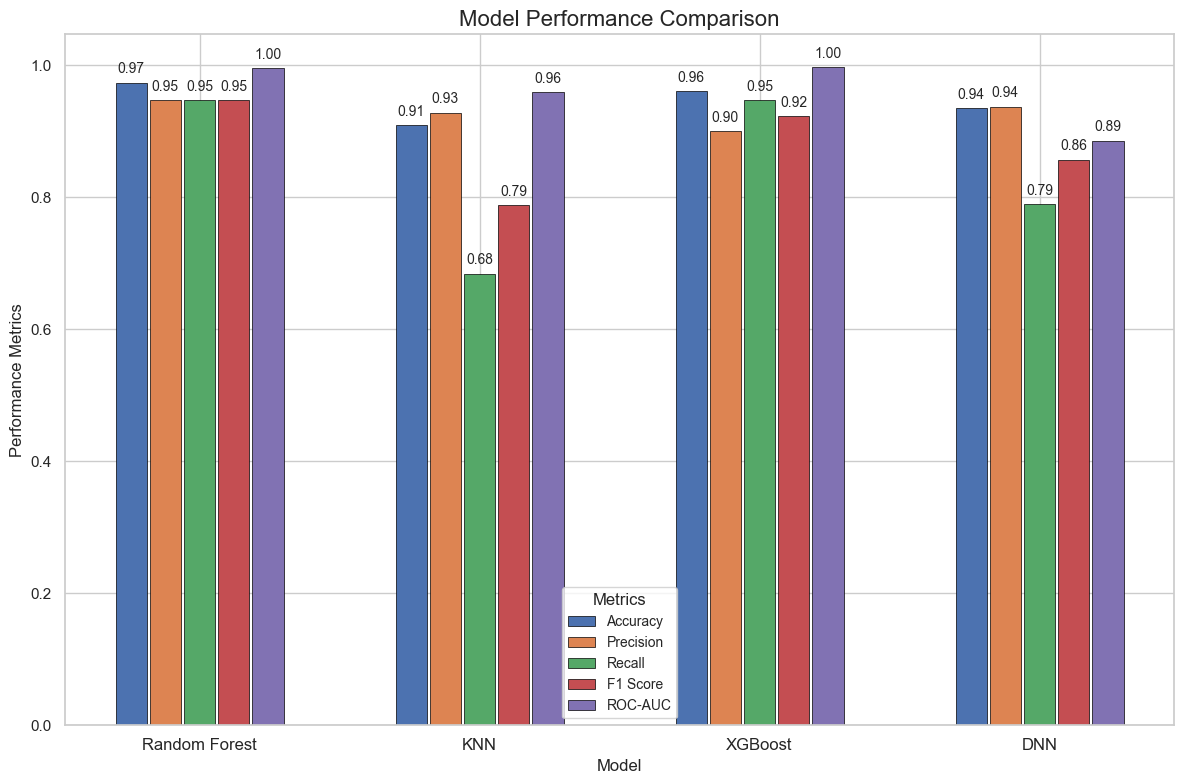

In [105]:
# Reset index to include model names as a column
results_reset = results_df.reset_index().rename(columns={'index': 'Model'})

# Metrics to plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

n_metrics = len(metrics)
x = np.arange(len(results_reset['Model'])) * (n_metrics - 0.5)  # Reduced gap between groups
width = 0.5  # Increased bar width
spacing = 0.05  # Smaller gap within groups

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each metric as a group of bars
for i, metric in enumerate(metrics):
    ax.bar(x + i * (width + spacing), results_reset[metric], width, label=metric, edgecolor='black', linewidth=0.5, capstyle='round')

# Add details to the plot
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Performance Metrics', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xticks(x + (n_metrics - 1) * (width + spacing) / 2)
ax.set_xticklabels(results_reset['Model'], fontsize=12)
ax.legend(title="Metrics", fontsize=10)

# Add values on top of the bars
for i, metric in enumerate(metrics):
    for j, value in enumerate(results_reset[metric]):
        ax.text(x[j] + i * (width + spacing), value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\3527003951.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\3527003951.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\3527003951.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\3527003951.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` 

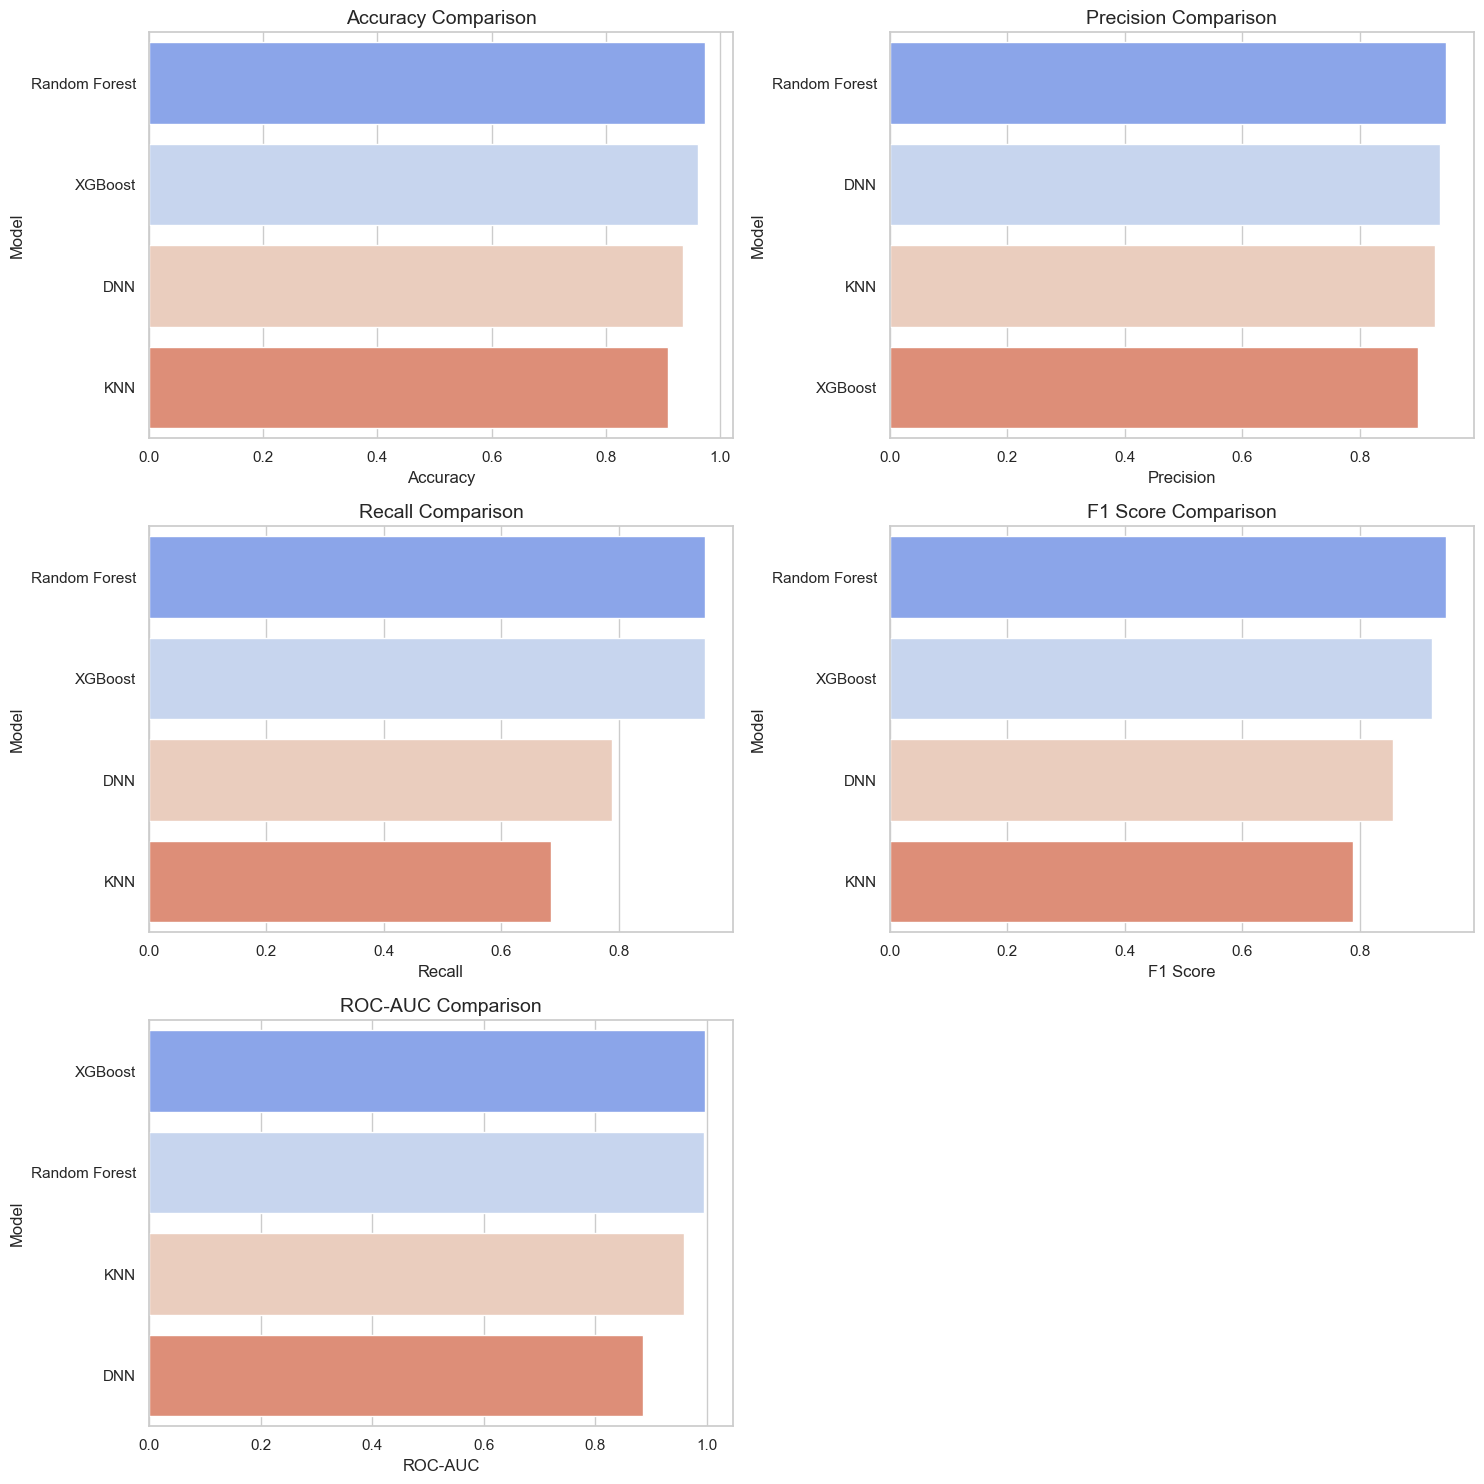

In [106]:
# Plot each metric in separate subplots
sns.set(style="whitegrid")
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if metric in results_reset.columns:
        sns.barplot(
            x=metric,
            y="Model",
            data=results_reset.sort_values(by=metric, ascending=False),
            ax=axes[i],
            palette="coolwarm"
        )
        axes[i].set_title(f"{metric} Comparison", fontsize=14)
        axes[i].set_xlabel(metric, fontsize=12)
        axes[i].set_ylabel("Model", fontsize=12)

# Remove any unused subplots
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\3986756628.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\3986756628.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\3986756628.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\3986756628.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

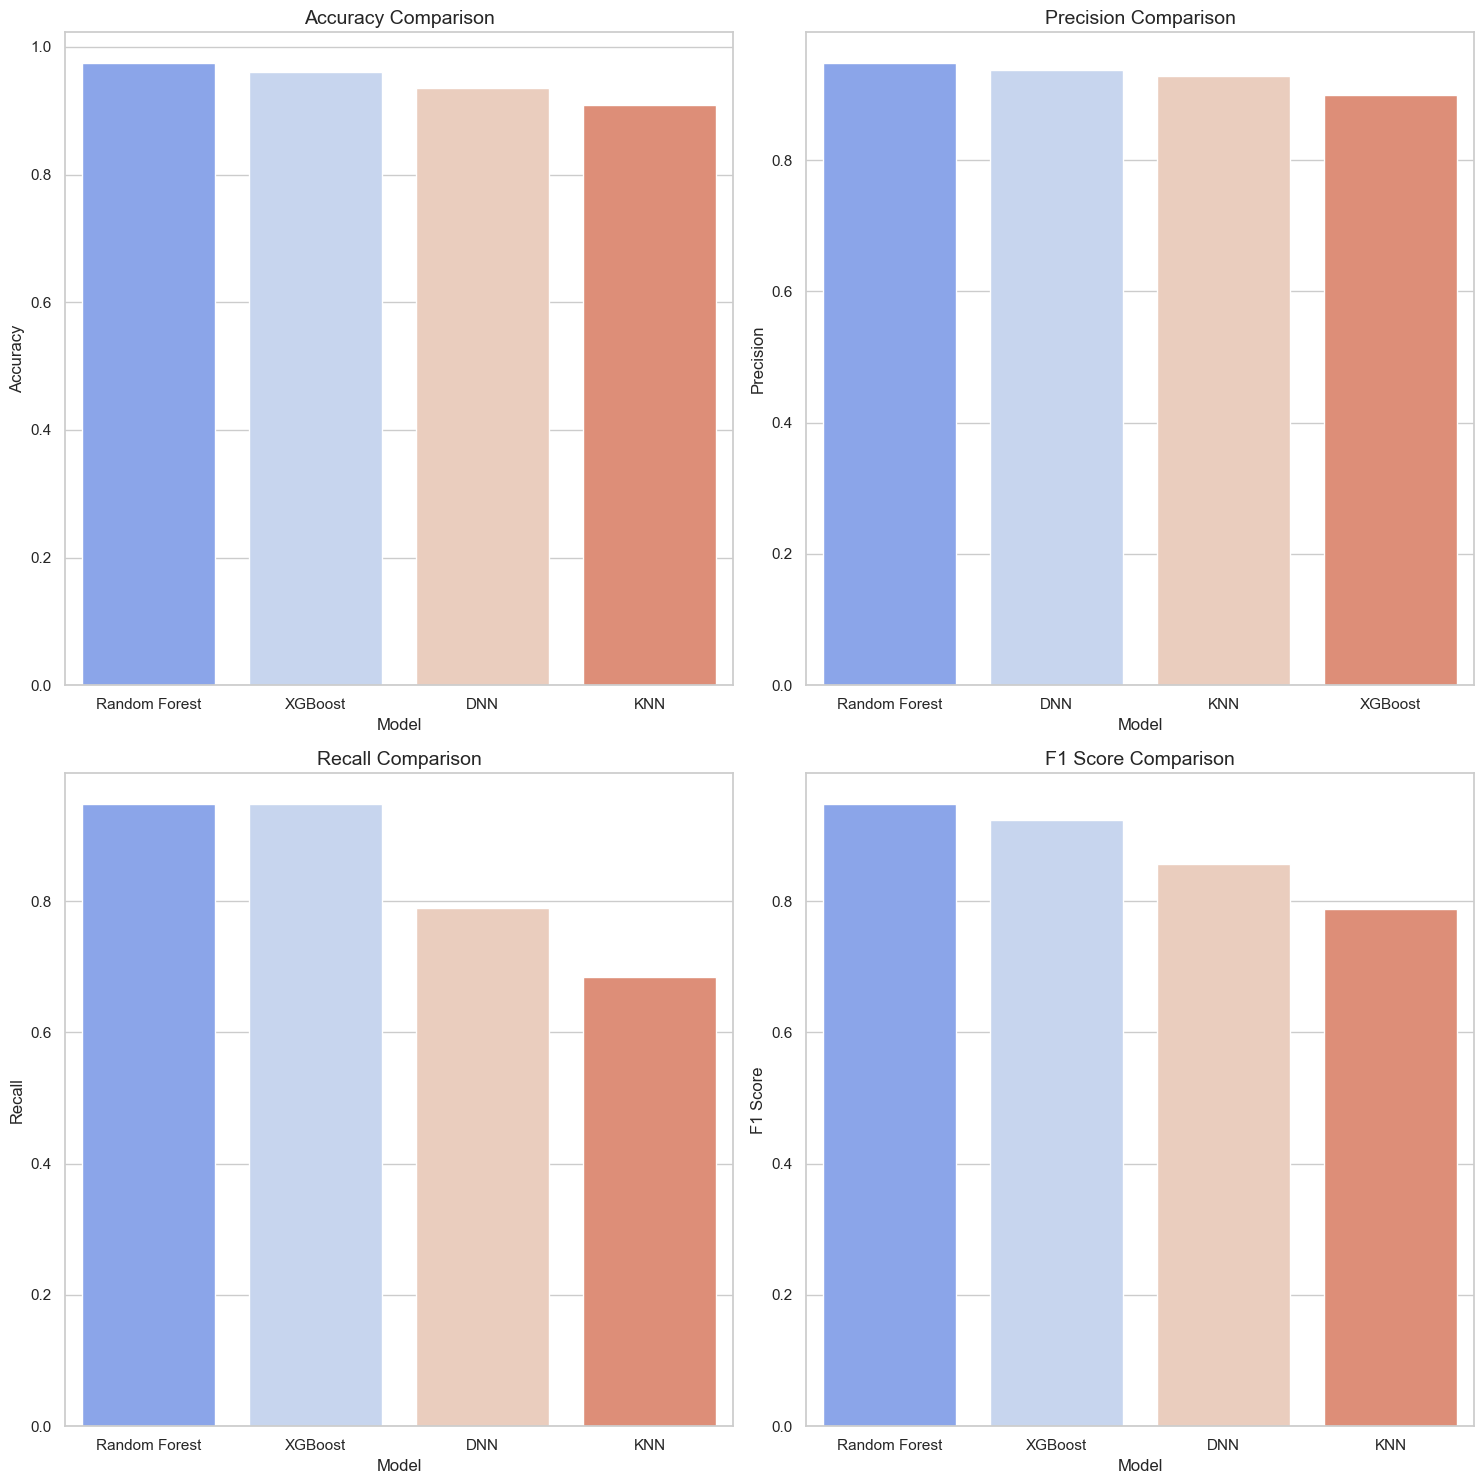

In [107]:
# Plot each metric in separate subplots
sns.set(style="whitegrid")
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    if metric in results_reset.columns:
        sns.barplot(
            x="Model",  # Model names on x-axis
            y=metric,  # Metric values on y-axis
            data=results_reset.sort_values(by=metric, ascending=False),
            ax=axes[i],
            palette="coolwarm"  # Color palette
        )
        axes[i].set_title(f"{metric} Comparison", fontsize=14)
        axes[i].set_xlabel("Model", fontsize=12)
        axes[i].set_ylabel(metric, fontsize=12)

# Remove any unused subplots (for ROC-AUC or fewer metrics)
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()

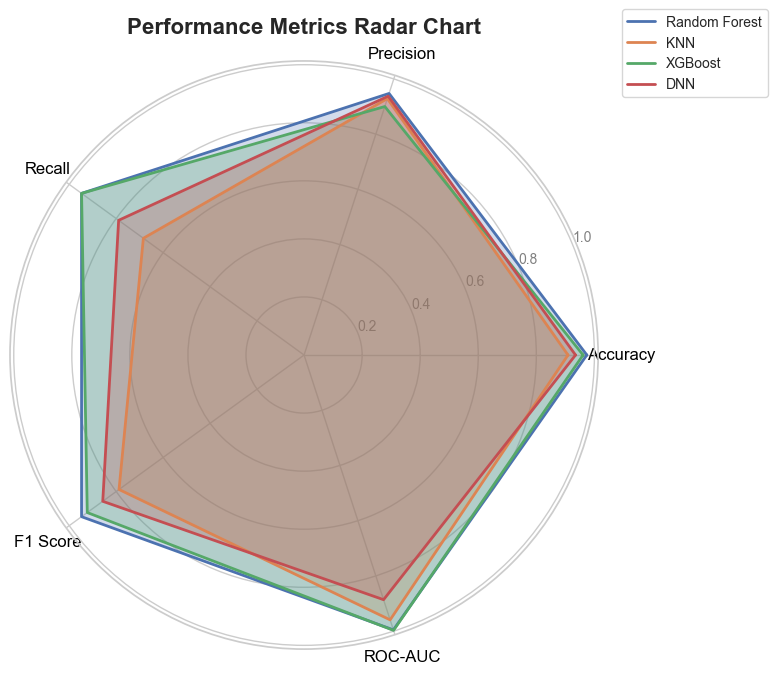

In [110]:
# Assuming the structure of results DataFrame as follows
categories = list(results_df.columns)  # Performance metrics
N = len(categories)

# Add the first category to close the circle
values_rf = results_df.iloc[0, :].tolist() + [results_df.iloc[0, 0]]
values_knn = results_df.iloc[1, :].tolist() + [results_df.iloc[1, 0]]
values_xgb = results_df.iloc[2, :].tolist() + [results_df.iloc[2, 0]]
values_dnn = results_df.iloc[3, :].tolist() + [results_df.iloc[3, 0]]

# Calculate the angles for each category
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Initialize radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model's data
ax.plot(angles, values_rf, label='Random Forest', linewidth=2, linestyle='solid')
ax.fill(angles, values_rf, alpha=0.25)

ax.plot(angles, values_knn, label='KNN', linewidth=2, linestyle='solid')
ax.fill(angles, values_knn, alpha=0.25)

ax.plot(angles, values_xgb, label='XGBoost', linewidth=2, linestyle='solid')
ax.fill(angles, values_xgb, alpha=0.25)

ax.plot(angles, values_dnn, label='DNN', linewidth=2, linestyle='solid')
ax.fill(angles, values_dnn, alpha=0.25)

# Add labels and title
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], color="gray", size=10)
ax.set_xticks(angles[:-1])  # Remove the last angle to avoid overlap
ax.set_xticklabels(categories, fontsize=12, color='black')
ax.set_title("Performance Metrics Radar Chart", fontsize=16, weight='bold', pad=20)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

### Hyperparameter Tuning Model Comparision

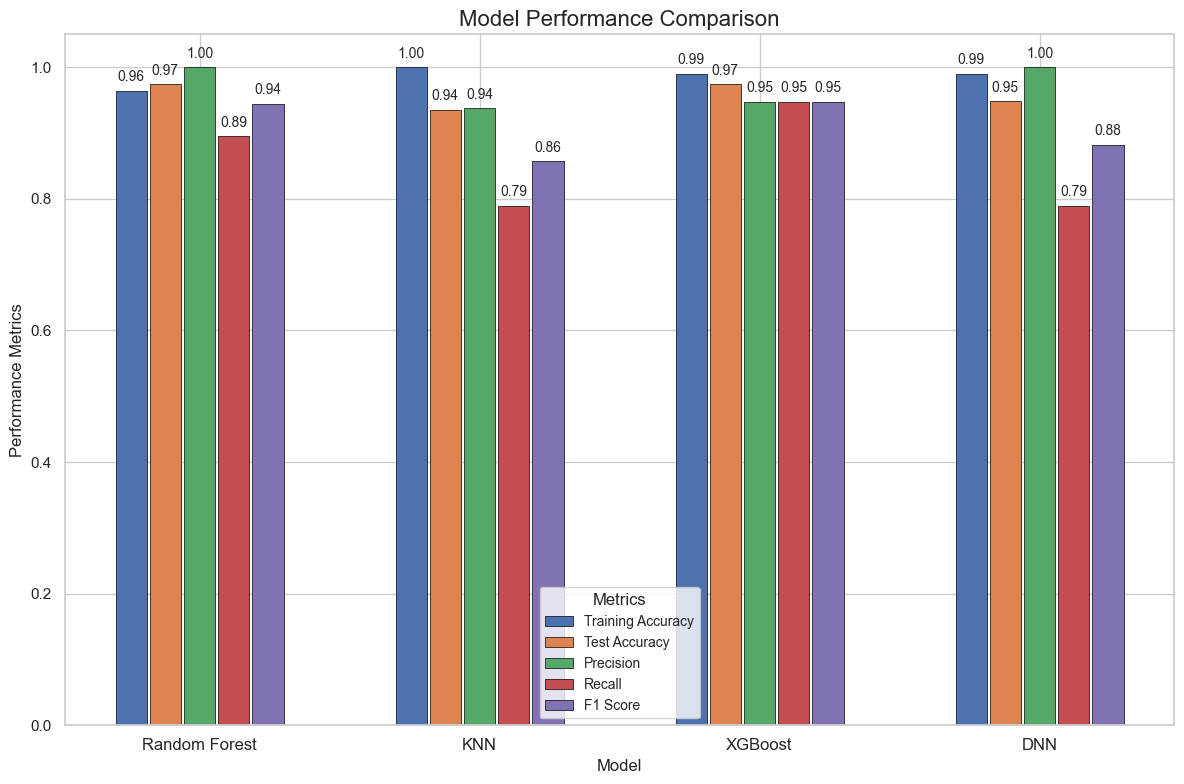

In [112]:
# Reset index to include model names as a column
results_reset_hyper = results_hyper_df.reset_index().rename(columns={'index': 'Model'})

# Metrics to plot
metrics = ["Training Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score"]

n_metrics = len(metrics)
x = np.arange(len(results_reset_hyper['Model'])) * (n_metrics - 0.5)  # Reduced gap between groups
width = 0.5  # Increased bar width
spacing = 0.05  # Smaller gap within groups

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each metric as a group of bars
for i, metric in enumerate(metrics):
    ax.bar(x + i * (width + spacing), results_reset_hyper[metric], width, label=metric, edgecolor='black', linewidth=0.5, capstyle='round')

# Add details to the plot
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Performance Metrics', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xticks(x + (n_metrics - 1) * (width + spacing) / 2)
ax.set_xticklabels(results_reset_hyper['Model'], fontsize=12)
ax.legend(title="Metrics", fontsize=10)

# Add values on top of the bars
for i, metric in enumerate(metrics):
    for j, value in enumerate(results_reset_hyper[metric]):
        ax.text(x[j] + i * (width + spacing), value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\1262385258.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\1262385258.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\1262385258.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hamma\AppData\Local\Temp\ipykernel_12060\1262385258.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

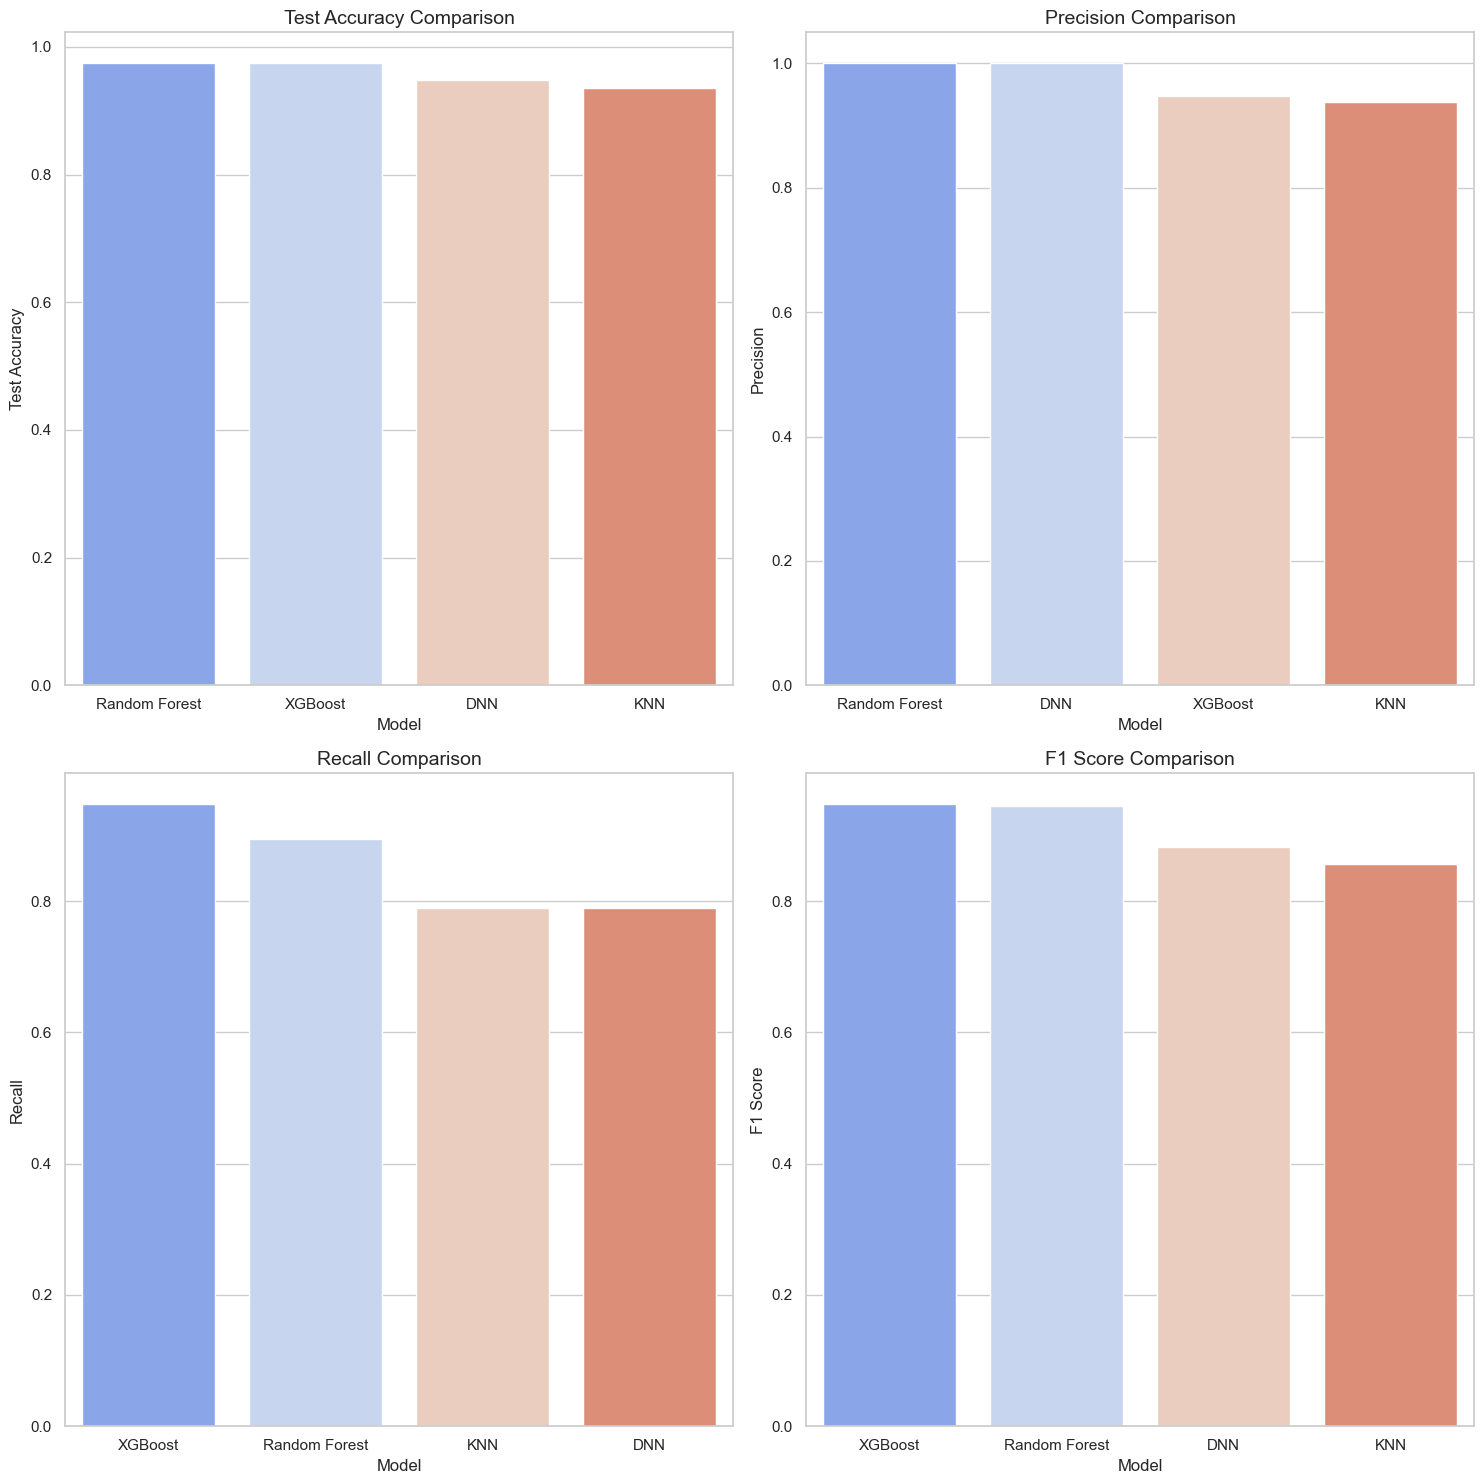

In [113]:
# Plot each metric in separate subplots
sns.set(style="whitegrid")
metrics = ["Test Accuracy", "Precision", "Recall", "F1 Score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    if metric in results_reset_hyper.columns:
        sns.barplot(
            x="Model",  # Model names on x-axis
            y=metric,  # Metric values on y-axis
            data=results_reset_hyper.sort_values(by=metric, ascending=False),
            ax=axes[i],
            palette="coolwarm"  # Color palette
        )
        axes[i].set_title(f"{metric} Comparison", fontsize=14)
        axes[i].set_xlabel("Model", fontsize=12)
        axes[i].set_ylabel(metric, fontsize=12)

# Remove any unused subplots (for ROC-AUC or fewer metrics)
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()

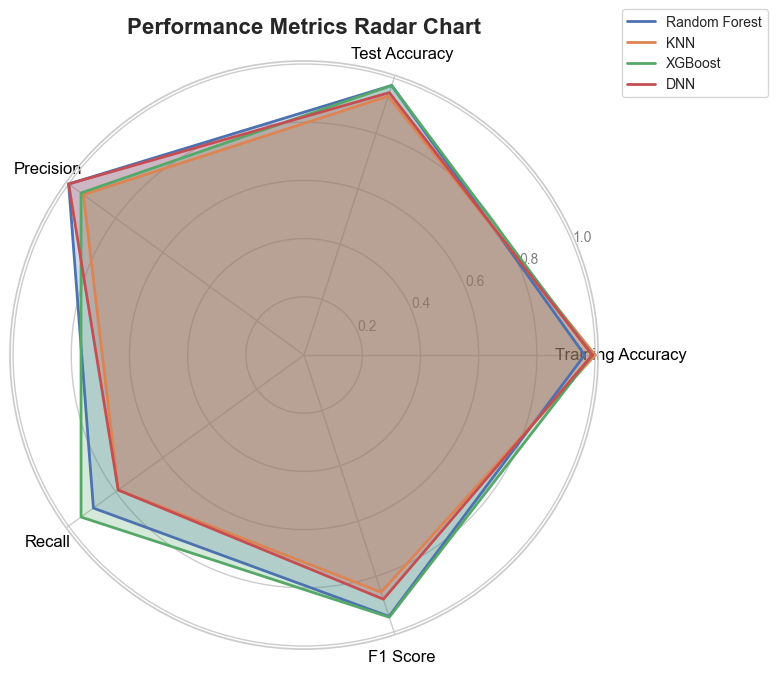

In [114]:
# List the metrics (excluding 'Best Parameters')
metrics = ['Training Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']

# Extract categories (performance metrics only)
categories = metrics  # Manually define the categories to exclude 'Best Parameters'
N = len(categories)

# Add the first category to close the circle
values_rf = results_hyper_df.iloc[0, 0:5].tolist() + [results_hyper_df.iloc[0, 0]]  # exclude Best Parameters
values_knn = results_hyper_df.iloc[1, 0:5].tolist() + [results_hyper_df.iloc[1, 0]]  # exclude Best Parameters
values_xgb = results_hyper_df.iloc[2, 0:5].tolist() + [results_hyper_df.iloc[2, 0]]  # exclude Best Parameters
values_dnn = results_hyper_df.iloc[3, 0:5].tolist() + [results_hyper_df.iloc[3, 0]]  # exclude Best Parameters

# Calculate the angles for each category
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Initialize radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model's data
ax.plot(angles, values_rf, label='Random Forest', linewidth=2, linestyle='solid')
ax.fill(angles, values_rf, alpha=0.25)

ax.plot(angles, values_knn, label='KNN', linewidth=2, linestyle='solid')
ax.fill(angles, values_knn, alpha=0.25)

ax.plot(angles, values_xgb, label='XGBoost', linewidth=2, linestyle='solid')
ax.fill(angles, values_xgb, alpha=0.25)

ax.plot(angles, values_dnn, label='DNN', linewidth=2, linestyle='solid')
ax.fill(angles, values_dnn, alpha=0.25)

# Add labels and title
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], color="gray", size=10)
ax.set_xticks(angles[:-1])  # Remove the last angle to avoid overlap
ax.set_xticklabels(categories, fontsize=12, color='black')
ax.set_title("Performance Metrics Radar Chart", fontsize=16, weight='bold', pad=20)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

# Show plot
plt.tight_layout()
plt.show()
